## **Training Artificial Neural Network on Predictive Maintenance Dataset**

### **Importing Libraries**

In [105]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

### Data Collection
### Reading Dataset downloaded from Kaggle 
https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

In [106]:
# Importing dataset
df= pd.read_csv("predictive.csv")

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

#### **Columns or Features Description**

- UID: unique identifier ranging from 1 to 10000
- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- type: just the product type L, M or H from column 2
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
The machine failure consists of five independent failure modes

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
- If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

## **Data Preprocessing**

In [109]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [110]:
df.drop(["UDI", "Product ID","RNF","OSF","PWF","HDF","TWF"], axis=1, inplace=True)

In [111]:
df.shape

(10000, 7)

In [112]:
# To show the features of dataset
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure'],
      dtype='object')

In [113]:
# To show statistical summary of the columns of dataset
df.describe(include="all")

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN
top,L,NaN,NaN,NaN,NaN,NaN,NaN
freq,6000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000


In [114]:
# To count the null values
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
dtype: int64

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [116]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [117]:
df.head(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


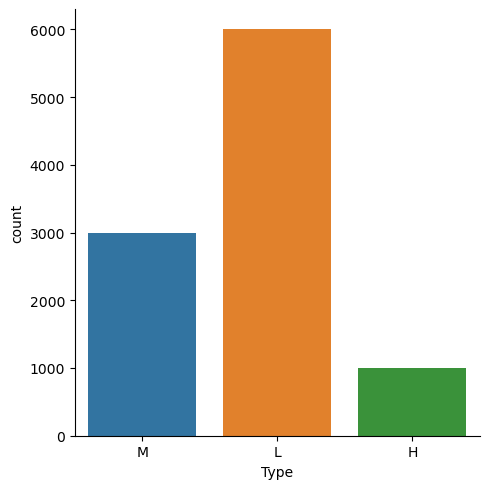

In [118]:
df_cat= ['Type','Machine failure']
sns.catplot(x='Type',kind='count', data=df,orient='h')

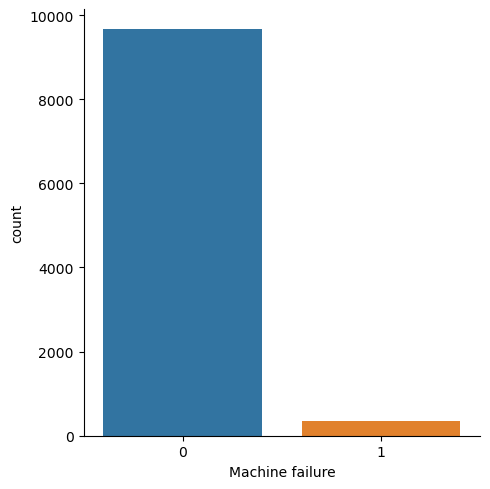

In [119]:
sns.catplot(x='Machine failure',kind='count', data=df,orient='h')

In [120]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [121]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[(df['Machine failure']==0)] 
df_minority = df[(df['Machine failure']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 9661, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [122]:
df_upsampled['Machine failure'].value_counts()

1    9661
0    9661
Name: Machine failure, dtype: int64

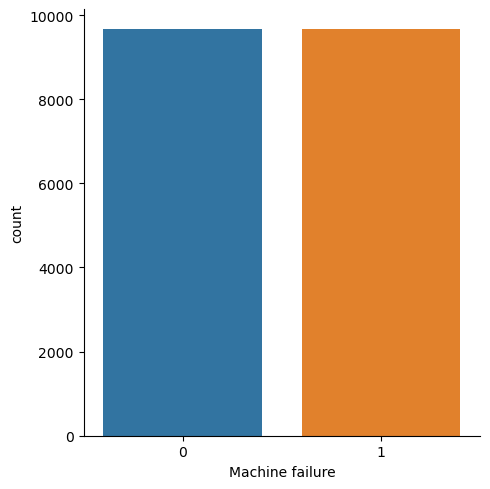

In [123]:
sns.catplot(x='Machine failure',kind='count', data=df_upsampled,orient='h')

In [124]:
df_upsampled.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure'],
      dtype='object')

In [125]:
df_numeric = [ 'Air temperature [K]', 'Process temperature [K]',
              'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

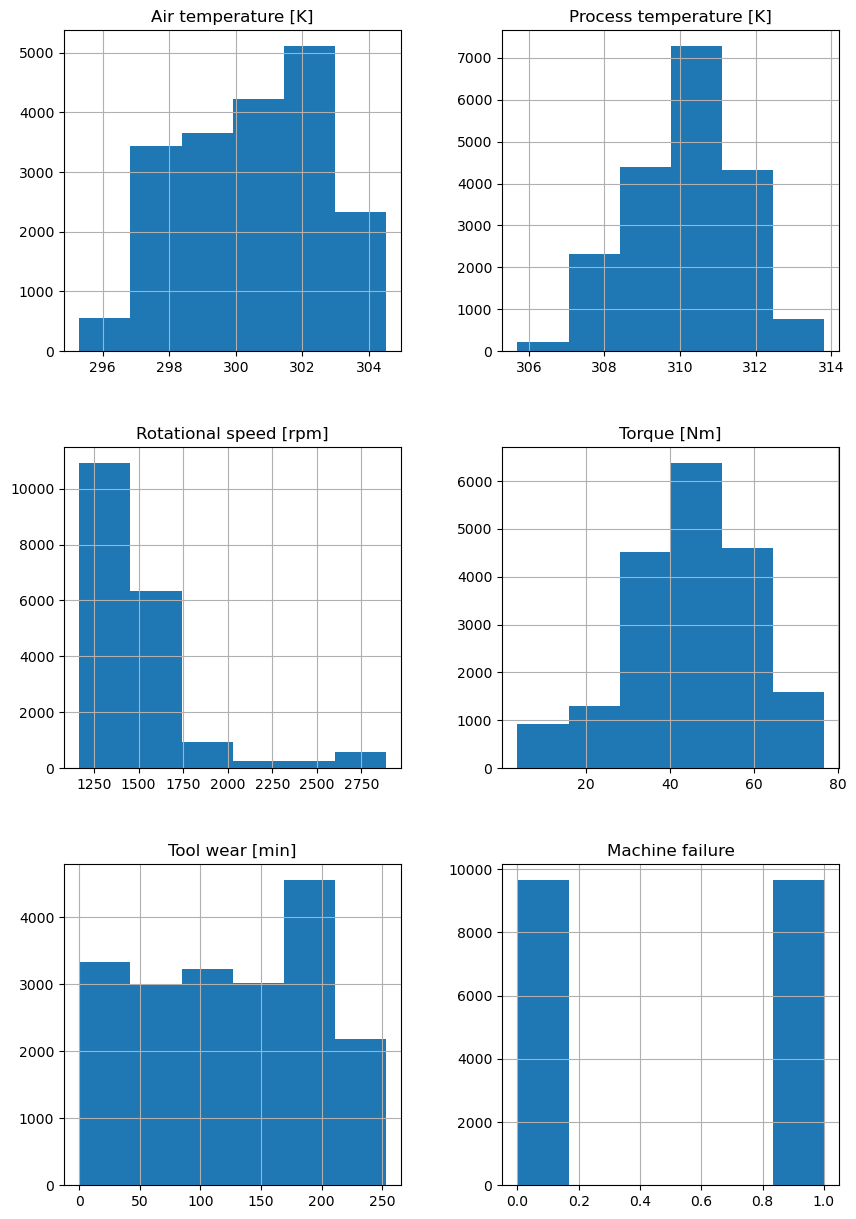

In [126]:
num_bins = 6
df_upsampled.hist(bins=num_bins,figsize=(10,15))
#plt.savefig("histogram_v1.png")
plt.show()

In [127]:
# Create dummy variables for the 'Type' column using the get_dummies() function from Pandas
# The 'Type' column is passed as the first parameter to get_dummies()

type1= pd.get_dummies(df_upsampled["Type"])

# Display the first few rows of the resulting DataFrame 'type'
type1.head()

,H,L,M
4024,0,0,1
6618,0,0,1
4048,0,1,0
2864,1,0,0
4596,0,1,0


In [128]:
df_upsampled.drop(["Type"], axis=1, inplace=True)

In [129]:
#displaying our data after dropping columns
df_upsampled.head(1)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
4024,302.1,311.0,1351,60.3,207,1


In [130]:
df_1 = pd.concat([type1,df_upsampled], axis=1)

In [131]:
df_1.head(4)

,H,L,M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
4024,0,0,1,302.1,311.0,1351,60.3,207,1
6618,0,0,1,301.6,310.6,1309,65.8,75,1
4048,0,1,0,301.9,311.0,2691,12.1,31,1
2864,1,0,0,300.6,309.4,1380,47.6,246,1


## Feature Selection

In [132]:
X = df_1.drop('Machine failure', axis=1)
y = df_1['Machine failure']


In [133]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [134]:
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)

In [135]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [136]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores

,Features,Score
0,H,91.699937
1,L,70.134376
2,M,58.194160
3,Air temperature [K],13.475922
4,Process temperature [K],1.249640
5,Rotational speed [rpm],6682.505697
6,Torque [Nm],12150.194168
7,Tool wear [min],51768.667284


In [137]:
print(featureScores.nlargest(8,'Score'))

                  Features         Score
7          Tool wear [min]  51768.667284
6              Torque [Nm]  12150.194168
5   Rotational speed [rpm]   6682.505697
0                        H     91.699937
1                        L     70.134376
2                        M     58.194160
3      Air temperature [K]     13.475922
4  Process temperature [K]      1.249640


In [138]:
X.drop(['Process temperature [K]'], axis=1,inplace = True)
X.head(3)

,H,L,M,Air temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
4024,0,0,1,302.1,1351,60.3,207
6618,0,0,1,301.6,1309,65.8,75
4048,0,1,0,301.9,2691,12.1,31


In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [140]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15457, 7)
(3865, 7)
(15457,)
(3865,)


In [141]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [142]:
import keras
from keras.models import Sequential

from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Dense


In [143]:
# initializing ann
model = Sequential()
# Adding the first input layer and the first hidden layer
model.add(Dense(10, kernel_initializer='he_normal', activation='relu', input_shape=(7,)))

# Adding batch normalization before dropout
model.add(BatchNormalization())
model.add(Dropout(rate=0.1))

# Adding the second hidden layer
model.add(Dense(7, kernel_initializer='he_normal', activation='relu'))

# Adding batch normalization before dropout
model.add(BatchNormalization())
model.add(Dropout(rate=0.1))

# Adding the output layer
model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

In [144]:
# compiling the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [145]:
# fitting the model to the training set 
model_history = model.fit(X_train, y_train, validation_split = 0.2, validation_data = (X_test, y_test), epochs = 200,shuffle=True)

Epoch 1/200
484/484 [==============================] - 5s 3ms/step - loss: 0.5519 - accuracy: 0.7347 - val_loss: 0.3751 - val_accuracy: 0.8422
Epoch 2/200
484/484 [==============================] - 1s 3ms/step - loss: 0.4240 - accuracy: 0.8082 - val_loss: 0.3260 - val_accuracy: 0.8600
Epoch 3/200
484/484 [==============================] - 1s 3ms/step - loss: 0.3852 - accuracy: 0.8285 - val_loss: 0.3013 - val_accuracy: 0.8776
Epoch 4/200
484/484 [==============================] - 2s 3ms/step - loss: 0.3605 - accuracy: 0.8418 - val_loss: 0.2884 - val_accuracy: 0.8838
Epoch 5/200
484/484 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8510 - val_loss: 0.2820 - val_accuracy: 0.8885
Epoch 6/200
484/484 [==============================] - 2s 4ms/step - loss: 0.3422 - accuracy: 0.8542 - val_loss: 0.2805 - val_accuracy: 0.8869
Epoch 7/200
484/484 [==============================] - 2s 4ms/step - loss: 0.3278 - accuracy: 0.8608 - val_loss: 0.2764 - val_accuracy: 0.8906

In [146]:
history_dict=model_history.history
history_dict.keys() 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

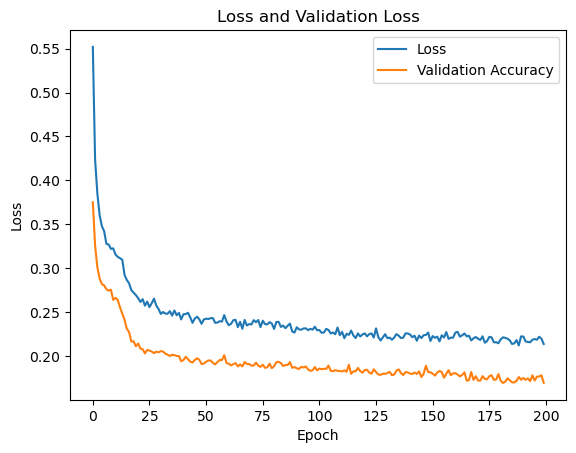

In [147]:
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Accuracy'], loc='upper right')
plt.show()

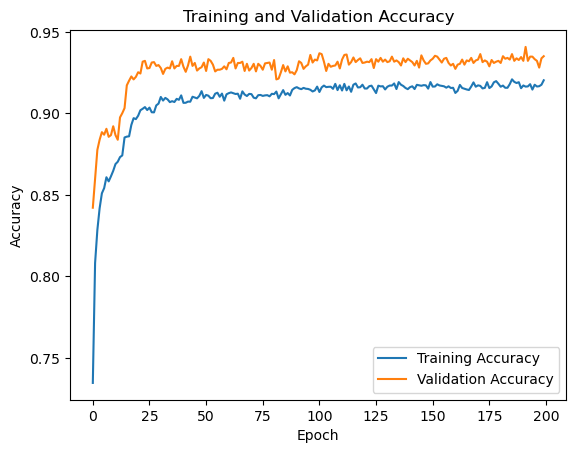

In [148]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [149]:
acc = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc}')

121/121 [==============================] - 0s 3ms/step - loss: 0.1698 - accuracy: 0.9351
Accuracy of model is 0.9350582361221313


In [150]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                80        
                                                                 
 batch_normalization_4 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 77        
                                                                 
 batch_normalization_5 (Bat  (None, 7)                 28        
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 7)                

In [151]:
from sklearn.metrics import classification_report
y_pre = []
for element in model.predict(X_test):
    if element > 0.5:
        y_pre.append(1)
    else:
        y_pre.append(0)

print(classification_report(y_test,y_pre))

121/121 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1923
           1       0.92      0.96      0.94      1942

    accuracy                           0.94      3865
   macro avg       0.94      0.93      0.94      3865
weighted avg       0.94      0.94      0.94      3865



121/121 [==============================] - 0s 2ms/step


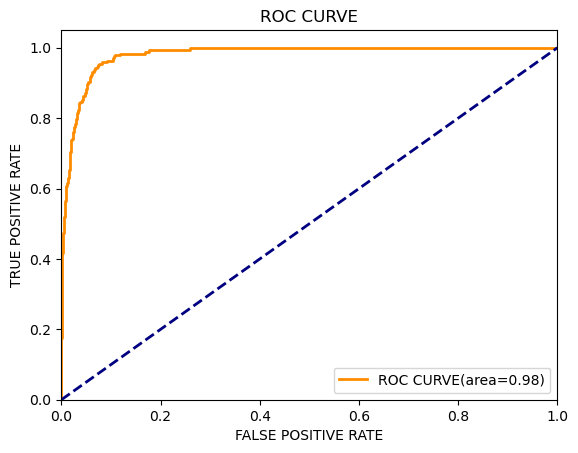

In [152]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
predictions = model.predict(X_test)
y_pre_prob =  predictions[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_pre_prob)
auc = metrics.roc_auc_score(y_test, y_pre_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',lw = lw, label = 'ROC CURVE(area=%0.2f)' %auc)
plt.plot([0,1],[0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC CURVE')
plt.legend(loc = 'lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1923
           1       0.92      0.96      0.94      1942

    accuracy                           0.94      3865
   macro avg       0.94      0.93      0.94      3865
weighted avg       0.94      0.94      0.94      3865



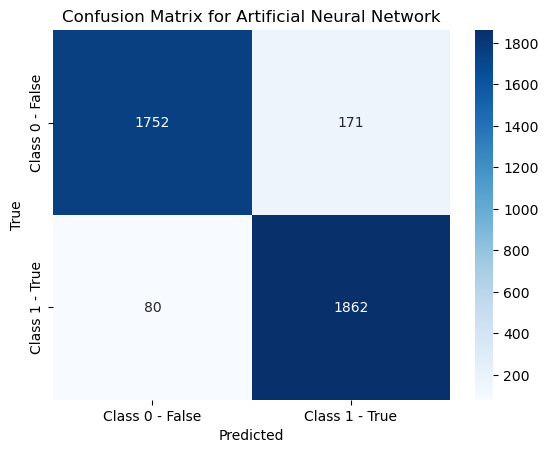

In [153]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have predictions (binary_predictions) from your model
binary_predictions = (predictions > 0.5).astype(int)

# Get class labels
class_labels = ['Class 0 - False', 'Class 1 - True']

# Print classification report
print(classification_report(y_test, binary_predictions))

# Create confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix with labels
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Artificial Neural Network')
plt.show()
